In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
tf.config.run_functions_eagerly(True)

In [2]:
#install kaggle untuk download dataset
! pip install -q kaggle

from google.colab import files

#upload kaggle API
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rizkysanjaya","key":"fe961784f1a9dad2bdef3fa0df36b89f"}'}

In [4]:
#buat directory kaggle
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
# Download the dataset
!kaggle datasets download -d landlord/handwriting-recognition

100% 1.26G/1.26G [00:45<00:00, 40.2MB/s]
100% 1.26G/1.26G [00:45<00:00, 30.0MB/s]


In [6]:
#extract zip dan pindahkan ke direktori baru
!mkdir Dataset
with zipfile.ZipFile("/content/handwriting-recognition.zip", "r") as zip_ref:
    zip_ref.extractall("/content/Dataset")

# Delete the zip file
os.remove("/content/handwriting-recognition.zip")

In [2]:
#pisah data dan view data
train = pd.read_csv('/content/Dataset/written_name_train_v2.csv')
valid = pd.read_csv('/content/Dataset/written_name_validation_v2.csv')

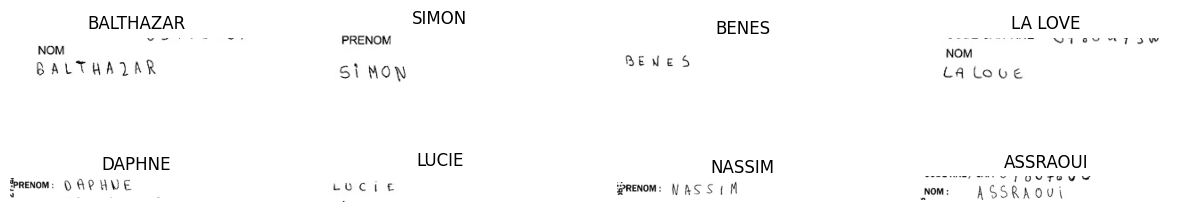

In [3]:
#preview sample data
plt.figure(figsize=(15, 10))

for i in range(8):
    ax = plt.subplot(2, 4, i+1)
    img_dir = '/content/Dataset/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [4]:
#cleaning process

# cek value kosong pada kolom train dan validation
train_missing_values = train.isnull().sum()
valid_missing_values = valid.isnull().sum()

# Hapus baris dengan value kosong
train.dropna(inplace=True)
valid.dropna(inplace=True)

# cek apakah data kosong sudah terhapus
train_missing_values_after_removal = train.isnull().sum()
valid_missing_values_after_removal = valid.isnull().sum()

# Print the number of missing values before and after removal
print("Train Missing values before removal:\n", train_missing_values)
print("Valid Missing values before removal:\n", valid_missing_values)
print("\nTrain Missing values after removal:\n", train_missing_values_after_removal)
print("\nValid Missing values after removal:\n", valid_missing_values_after_removal)





Train Missing values before removal:
 FILENAME      0
IDENTITY    565
dtype: int64
Valid Missing values before removal:
 FILENAME     0
IDENTITY    78
dtype: int64

Train Missing values after removal:
 FILENAME    0
IDENTITY    0
dtype: int64

Valid Missing values after removal:
 FILENAME    0
IDENTITY    0
dtype: int64


In [5]:
#hapus/ignore data tak terbaca dimana kolom "Identity" berlabel "unreadable"
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [6]:
#reset data frame index setelah cleaning process
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [7]:
#pre process data (resizing & rotating)
# def preprocess(image, width=256, height=64):
#   # Resize the image to the desired width and height.
#   resized_image = cv2.resize(image, (width, height))

#   # If the image is smaller than the desired size, pad it with white pixels.
#   if resized_image.shape[0] < width or resized_image.shape[1] < height:
#     pad_top = max(0, width - resized_image.shape[0])
#     pad_bottom = max(0, height - resized_image.shape[1])
#     pad_left = max(0, width - resized_image.shape[0])
#     pad_right = max(0, height - resized_image.shape[1])
#     pad_color = (255, 255, 255)
#     padded_image = cv2.copyMakeBorder(resized_image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=pad_color)
#   else:
#     padded_image = resized_image

#   # Rotate the image clockwise.
#   rotated_image = cv2.rotate(padded_image, cv2.ROTATE_90_CLOCKWISE)

#   return rotated_image

def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [8]:
#menentukan training dan validation data yang digunakan untuk training
#total data training set (331,059) dan validation set (41,382).
#menggunakan 70% data untuk training dan 15% untuk validation
train_images = 10000
valid_images= 1000



In [9]:
#loop untuk pre-process train & valid set
#buat array train
train_x = []

for i in range(train_images):
    #read file
    img_dir = '/content/Dataset/train_v2/train/'+train.loc[i, 'FILENAME']
    #convert to greyscale
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    #pre-process dengan fungsi diatas
    image = preprocess(image)
    #Normalizing the pixel values to the range of 0-1 
    image = image/255.
    #masukan image ke dalam array
    train_x.append(image)



In [10]:
#ulangi process diatas untuk validation set
valid_x = []

for i in range(valid_images):
    img_dir = '/content/Dataset/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [11]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [12]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels
batch_size = 128

def label_to_num(label):
    label_num = []
    for ch in label:
        
            label_num.append(alphabets.find(ch) if alphabets.find(ch)!=-1 else alphabets.find('-'))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [13]:
train.shape

(330294, 2)

In [ ]:
# path = '/kaggle/input/handwriting-recognition/train_v2/train/'

# counts = []
# for row, val in train.iloc[37000:40000].iterrows():
# #     pass
#     img_dir = os.path.join(path, val['FILENAME'])
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     counts.append(len(val['IDENTITY']))
# print(counts)

In [60]:
# directory = '/content/Dataset/train_v2/train/'

# def image_generator(path):
#         for row, val in  train.iterrows(): #need improvement
# #             try:
#                 img_dir = os.path.join(path, val['FILENAME'])
#                 image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#                 image = preprocess(image)[..., np.newaxis]
#         #         print(image.shape)
#                 image = image/255.
#                 if image.shape !=(256,64,1):
#                     break
#                 # train_label_len[i] = len(train.loc[i, 'IDENTITY'])
#                 if (len(val['IDENTITY'])>max_str_len):
#                     continue
#                 labels = label_to_num(val['IDENTITY'])    
#                 yield (image, labels)
# #             except Exception as e:
# #                 continue

In [61]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

In [62]:
# dataset = tf.data.Dataset.from_generator(lambda: image_generator(directory), (tf.float32, tf.float32))# , ([256, 64,1], [None]))
# def foo(*val):
#     xl = val[0]
#     lab = val[1]
#     lab_len = len(lab)
#     one_pad = -tf.ones((max_str_len - lab_len))#*(-1)
#     y = tf.concat([lab, one_pad], -1)
    
#     return xl, y, [num_of_timestamps-2], [lab_len], [0]
                  
# dataset = dataset.map(foo).batch(batch_size)
# dataset_final = dataset.map(lambda *x: (x[0:-1],x[-1])).prefetch(AUTOTUNE)

In [14]:
train_y = np.ones([train_images, max_str_len]) * -1
train_label_len = np.zeros([train_images, 1])
train_input_len = np.ones([train_images, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_images])

for i in range(train_images):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [15]:
valid_y = np.ones([valid_images, max_str_len]) * -1
valid_label_len = np.zeros([valid_images, 1])
valid_input_len = np.ones([valid_images, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_images])

for i in range(valid_images):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [16]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [17]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [18]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [19]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [20]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

history = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/60
79/79 [==============================] - 49s 468ms/step - loss: 31.6074 - val_loss: 36.0837
Epoch 2/60
79/79 [==============================] - 35s 441ms/step - loss: 20.7623 - val_loss: 23.3319
Epoch 3/60
79/79 [==============================] - 35s 444ms/step - loss: 20.3966 - val_loss: 20.9770
Epoch 4/60
79/79 [==============================] - 34s 435ms/step - loss: 20.2130 - val_loss: 20.6570
Epoch 5/60
79/79 [==============================] - 35s 445ms/step - loss: 20.1071 - val_loss: 20.4878
Epoch 6/60
79/79 [==============================] - 37s 468ms/step - loss: 20.0010 - val_loss: 20.3211
Epoch 7/60
79/79 [==============================] - 34s 435ms/step - loss: 19.8849 - val_loss: 20.1875
Epoch 8/60
79/79 [==============================] - 36s 453ms/step - loss: 19.7833 - val_loss: 20.0849
Epoch 9/60
79/79 [==============================] - 38s 478ms/step - loss: 19.6790 - val_loss: 19.9405
Epoch 10/60
79/79 [==============================] - 34s 430ms/step - los

In [21]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_images):
    prediction.append(num_to_label(decoded[i]))

32/32 [==============================] - 2s 64ms/step


In [22]:
y_true = valid.loc[0:valid_images, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_images):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_images))

Correct characters predicted : 73.47%
Correct words predicted      : 49.20%


In [ ]:
# # Plot the chart for accuracy and loss on both training and validation

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()

# plt.plot(epochs, loss, 'r', label='Training Loss')
# plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()